In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import astropy.units as u
from astropy.coordinates import Angle
from gammapy.spectrum import SensitivityEstimator, CountsSpectrum
from gammapy.irf import EffectiveAreaTable2D, Background2D, Background3D, PSF3D, EnergyDispersion2D


In [12]:
def load_sensitivity_reference():
    path = './CTA-Performance-prod3b-v1-South-20deg-50h-DiffSens.txt'
    df = pd.read_csv(
        path, delimiter='\t\t', skiprows=10, names=['e_min', 'e_max', 'sensitivity'], engine='python'
    )
    return df

def load_effective_area_requirement():
    path = './CTA-Performance-prod3b-v1-South-20deg-50h-EffArea.txt'
    df = pd.read_csv(
        path, delimiter='\t\t', skiprows=11, names=['energy', 'effective_area'], engine='python'
    )
    return df

def load_effective_area_requirement_no_cuts():
    path = './CTA-Performance-prod3b-v1-South-20deg-50h-EffAreaNoDirectionCut.txt'
    df = pd.read_csv(
        path, delimiter='\t\t', skiprows=11, names=['energy', 'effective_area'], engine='python'
    )
    return df

def plot_refrence(ax=None):
    df = load_sensitivity_reference()
    bin_edges = sorted(list(set(df.e_min) | set(df.e_max))) * u.TeV
    bin_center = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    sensitivity = df.sensitivity.values * u.erg / (u.cm ** 2 * u.s)

    if not ax:
        ax = plt.gca()

    xerr = [np.abs(bin_edges[:-1] - bin_center).value, np.abs(bin_edges[1:] - bin_center).value]
    ax.errorbar(
        bin_center.value, sensitivity.value, xerr=xerr, linestyle='', color='#3e3e3e', label='Reference'
    )
    return ax

def plot_effective_area_reference(ax=None):
    df = load_effective_area_requirement()
    
    if not ax:
        ax = plt.gca()
    ax.plot(df.energy, df.effective_area, '--', color='gray', label='Prod3b reference')
    
    df = load_effective_area_requirement_no_cuts()
    ax.plot(df.energy, df.effective_area, '--', color='gray', label='Prod3b reference')

In [13]:
offset = Angle("0 deg")

energy_reco = np.logspace(-1.7, 2.2, 20) * u.TeV
energy_true = np.logspace(-2.1, 2.4, 50) * u.TeV

In [14]:
filename = ('./../cta_irf.fits')
aeff = EffectiveAreaTable2D.read(filename, hdu="EFFECTIVE AREA")
bkg2d = Background2D.read(filename, hdu="BACKGROUND")
edisp = EnergyDispersion2D.read(filename, hdu="ENERGY DISPERSION")
psf = PSF3D.read(filename, hdu="PSF")

arf = aeff.to_effective_area_table(offset, energy=energy_true)
rmf = edisp.to_energy_dispersion(
     offset, e_true=energy_true, e_reco=energy_reco
)
psf = psf.to_energy_dependent_table_psf(theta=offset)

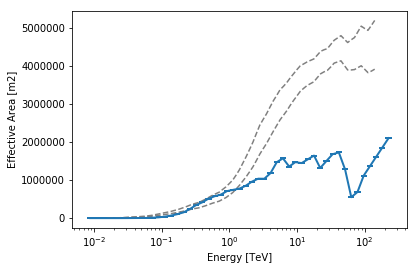

In [15]:
arf.plot()
plot_effective_area_reference()

In [16]:
containment = 0.68
energies = np.sqrt(energy_reco[1:] * energy_reco[:-1])
on_radii = psf.containment_radius(energies=energies, fraction=containment)
on_radii = np.clip(on_radii.to_value('deg'), 0, 2) * u.deg
on_radii[on_radii == 0] = 1*u.deg
solid_angles = 2 * np.pi * (1 - np.cos(on_radii)) * u.sr

arf.data.data *= containment

In [17]:
bkg_data = bkg2d.evaluate_integrate(
    fov_lon=0 * u.deg, fov_lat=offset, energy_reco=energy_reco
)
print(bkg_data.unit)
bkg = CountsSpectrum(
    energy_reco[:-1], energy_reco[1:], data=(bkg_data * solid_angles)
)
# bkg.data.data
(bkg.data.data.to("1/s") * (50*u.h).to(u.s)).value

TeV / (MeV s sr)


array([6.24401222e+03, 1.92981901e+03, 4.31439866e+02, 2.94197095e+02,
       1.25921376e+02, 5.67773325e+01, 2.14776157e+01, 6.34627890e+00,
       1.37899513e+00, 4.00011910e-01, 1.39892480e-01, 5.97765264e-02,
       1.12879592e-02, 6.49575078e-03, 4.32330573e-03, 1.40517528e-03,
       1.05344113e-03, 2.33593912e-01, 5.68090431e-02])

In [24]:
sensitivity_estimator = SensitivityEstimator(
    arf=arf, rmf=rmf, bkg=bkg, livetime="50h", gamma_min=5, sigma=5, alpha=0.2
)
sensitivity_table = sensitivity_estimator.run()


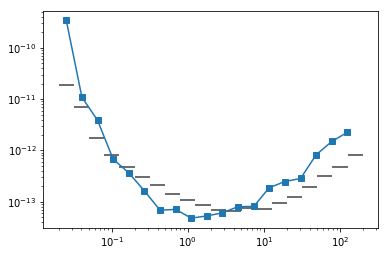

In [25]:
g = sensitivity_table['criterion'] == 'significance'
plt.plot(
    sensitivity_table["energy"][g],
    sensitivity_table["e2dnde"][g],
    "s-",
)
plt.plot(
    sensitivity_table["energy"][~g],
    sensitivity_table["e2dnde"][~g],
    "s-",
)
plot_refrence()
plt.xscale('log')
plt.yscale('log')

In [26]:
sensitivity_table

energy,e2dnde,excess,background,criterion
TeV,erg / (cm2 s),,,
float64,float64,float64,float64,str12
0.0252715,3.42364e-10,438.629,6244.01,significance
0.040541,1.08967e-11,246.429,1929.82,significance
0.0650366,3.87641e-12,119.567,431.44,significance
0.104333,6.7409e-13,99.7388,294.197,significance
0.167373,3.65776e-13,67.2384,125.921,significance
0.268502,1.63078e-13,47.0283,56.7773,significance
0.430735,6.82865e-14,31.1164,21.4776,significance
0.690993,7.08976e-14,19.513,6.34628,significance
